# 1.Text Cleaning Overview

### Step 1.Data Cleaning, impute `City` & `Attraction_Rank` Columns, Google api Translate to English if needed
1&2. We impute `City` & `Attraction_Rank` Columns in each city<br>
3.Google api Translate, `Require_Translate` column show English translation is required or not.<br>
`Require_Translate` is scrpaed from translate tag. Show whether the observed review should be translated in English or not<br>

### Step 2.Review-`Date` cleaning
4.Review-`Date` cleaning, find earliest date of first date in each cities and drop all date before that.<br>

### Step 3. Tokenizing
We create TextProcessor Class. And We choose mode 0, lower-case and remove stop-words. Also, we add regex rules to select emojs and '!' characters.<br>
Special characters copy from original text: ❤️😠💜🙏😄🤩😁👏 PERFECT **!!!!** ⭐️ 🤩♥️ 😀💚 💯👍🏼<br>
Some Tokenize Results: 'good three islands beautiful reason recommend visit 😉❤️', 'unfortunately make trip got lost found booth trips said got lost able use trip next day great thank much 😄 🙂 👍👍', 'great trip **!!**'<br>

In [40]:
'''
!pip install pandas
!pip install nltk
!pip install spacy
!pip install scikit-learn
!pip install matplotlib
!pip install matplotlib seaborn
!pip install tqdm
!python -m spacy download en_core_web_sm
# translate
#!pip install google-cloud-translate
#!pip install googletrans
!pip install googletrans==3.1.0a0
!pip install langdetect # detect wehter is english
'''

'\n!pip install pandas\n!pip install nltk\n!pip install spacy\n!pip install scikit-learn\n!pip install matplotlib\n!pip install matplotlib seaborn\n!pip install tqdm\n!python -m spacy download en_core_web_sm\n# translate\n#!pip install google-cloud-translate\n!pip install googletrans\n!pip install langdetect # detect wehter is english\n'

In [2]:
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

# google translate api
#from google.cloud import translate_v2 as translate
from googletrans import Translator

In [3]:
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\surface\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\surface\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\surface\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
import pandas as pd
import numpy as np
import csv
from itertools import islice #slice objects of dictionary

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.stem import SnowballStemmer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

#!python -m spacy download en_core_web_sm
import spacy

import re
from collections import Counter

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD


import os

from tqdm import tqdm
tqdm.pandas()

# 2. Data Cleaning

### 0. Missing Rate in each Columns, histgram

This plots is created in future steps. For the aim of convenient and intuitive, we just put in the beginning

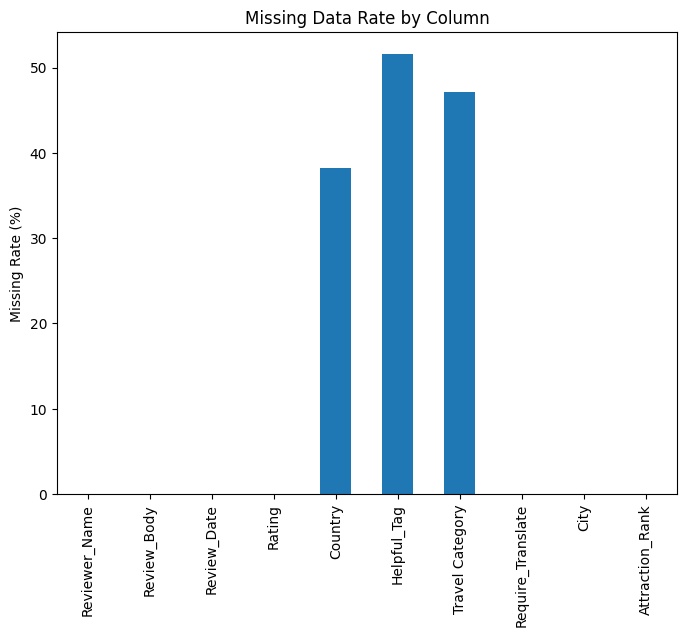

In [45]:
'''missing_rate = combined_df.isnull().mean() * 100
# Plotting
plt.figure(figsize=(8, 6))
missing_rate.plot(kind='bar')
plt.ylabel('Missing Rate (%)')
plt.title('Missing Data Rate by Column')
plt.show()'''

###### We are able to observed that name, review body, date, rating, city, Attraction_Rank are all non-missing. Country is lowest missing column = 40%, Helpful_Tag & Travel_Category is missing in about 50%

### 1. Load file, review scraped cities of top 1 or top 2 attractions

In [2]:
directory_path = 'C:/Users/surface/DSDM/Semesters/semester2/text mining/Final Project/downloads/'
csv_files = os.listdir(directory_path)

# Create a dictionary to store df of each cities
dataframes = {}

for file in csv_files:
    if file.endswith('.csv') and ('Booking-top1' in file or 'Booking-top2' in file):
        # Extract the city name and top rank from the file name
        # Assuming the file name format is "{city_name}_Attraction_Reviews_Booking-top{rank}.csv"
        parts = file.split('_')
        city_name = parts[0]  # city name
        parts = file.split('-')
        top_rank = parts[-1].replace('.csv', '') # rank

        # Construct key
        dict_key = f"{city_name}:{top_rank}"

        # Construct the full file path
        file_path = os.path.join(directory_path, file)
        df = pd.read_csv(file_path)
        if dict_key in dataframes:
            # if multiple keys, handle differently
            print(f"Multiple files for {dict_key}. Consider handling duplicates.")
        dataframes[dict_key] = df

barcelona_top1_df = dataframes['Barcelona:top1']
barcelona_top1_df.head()

,Reviewer_Name,Review_Body,Review_Date,Rating,Country,Helpful_Tag,Travel Category,Require_Translate
0,Massimo,Mai vista una bellezza simile: unica ed inegua...,2024-03-17,5,NaN,Helpful,a partner or spouse,True
1,Federico,There are no comments available for this review,2024-03-17,5,United States,NaN,family,False
2,Yvonne,Die Kathedrale ist absolut phantastisch! Der A...,2024-03-16,4,Germany,Helpful,a partner or spouse,True
3,Sanjayh,There are no comments available for this review,2024-03-16,5,India,NaN,family,False
4,Anonymous,There are no comments available for this review,2024-03-16,2,NaN,NaN,NaN,False


### 2. We have to impute `City` & `Attraction_Rank` Columns in each

In [3]:
for key, df in dataframes.items():
    # Extract city name
    city_name = key.split(':')[0]
    # Impute city column
    df['City'] = city_name
    dataframes[key] = df
barcelona_top1_df = dataframes['Barcelona:top1']
display(barcelona_top1_df['City'].head())

0    Barcelona
1    Barcelona
2    Barcelona
3    Barcelona
4    Barcelona
Name: city, dtype: object

In [13]:
for city_rank, df in dataframes.items():
    # key = "CityName:topRank"
    # Split the key to extract the rank information
    _, rank = city_rank.split(':')
    
    # Impute or fill in the Attraction_Rank column with the extracted rank
    df['Attraction_Rank'] = rank
    
    # Modift dataframes
    dataframes[city_rank] = df

barcelona_top1_df = dataframes['Barcelona:top1']
display(barcelona_top1_df['Attraction_Rank'].head())

0    top1
1    top1
2    top1
3    top1
4    top1
Name: Attraction_Rank, dtype: object

### 3. Google api Translate, `Require_Translate` column show English translation require or not.
`Require_Translate` is scrpaed from translate tag. Show whether the observed review should be translated in English or not

In [4]:
# example
translator = Translator(service_urls=['translate.googleapis.com'])
translated = translator.translate('Mai vista una bellezza simile: unica ed ineguagliabile, da togliere il fiato!', dest='en')
print(translated.text)

Never seen such beauty: unique and unparalleled, breathtaking!


In [5]:
translator = Translator()

def translate_text(text, count):
    print("Text:",text)
    try:
        # Translate text to English
        translated = translator.translate(text, dest='en')
        print("Translated:", translated.text)
        count = count + 1
        print("Translated Num: ", count)
        return translated.text
    except Exception as e:
        print(f"Error translating text: {e}")
        # Return original text if translation fails
        return text
# iterate over cities and rank
count = 0
for city, df in dataframes.items():
    print("DataFrame of City&Rank:",city)
    # Check if 'Require_Translate' is True and then apply translation
    mask = df['Require_Translate'] == True
    if mask.any():
        df.loc[mask, 'Review_Body'] = df.loc[mask, 'Review_Body'].apply(translate_text, count)
    
    # Update the DataFrame in the dictionary
    dataframes[city] = df

DF of City&Rank: Barcelona:top1
Text: Mai vista una bellezza simile: unica ed ineguagliabile, da togliere il fiato!
Translated: Translated(src=it, dest=en, text=Never seen such beauty: unique and unparalleled, breathtaking!, pronunciation=Never seen such beauty: unique and unparalleled, breathtaking!, extra_data="{'translat...")
Translated: Never seen such beauty: unique and unparalleled, breathtaking!
Text: Die Kathedrale ist absolut phantastisch! Der Audioguide war mit Hilfe vor Ort einfach herunter zu laden. Leider waren die Stationen zu den einzelnen Hörpunkten etwas schwierig zu finden. Wir sind nicht sicher, ob es an den vielen Besuchern gelegen hat, dass es ein wenig unübersichtlich war
Translated: Translated(src=de, dest=en, text=The cathedral is absolutely fantastic! The audio guide was easy to download with help on site. Unfortunately, the stations to the individual listening points were a bit difficult to find. We're not sure whether it was because of the large number of vis

#### Found some special Characters in side reviews -> We try keep them in future tokenizea
##### ❤️😠💜🙏😄🤩😁👏 PERFECT!!!! ⭐️ 🤩♥️ 😀💚 💯👍🏼

## We save a copy here. Imputed with `City` Column and Cleaned with Google Translated

In [16]:
combined_df = pd.concat(dataframes.values())
display(combined_df.head())
print(combined_df.describe())
print(combined_df.info())

,Reviewer_Name,Review_Body,Review_Date,Rating,Country,Helpful_Tag,Travel Category,Require_Translate,City,Attraction_Rank
0,Massimo,Never seen such beauty: unique and unparallele...,2024-03-17,5,NaN,Helpful,a partner or spouse,True,Barcelona,top1
1,Federico,There are no comments available for this review,2024-03-17,5,United States,NaN,family,False,Barcelona,top1
2,Yvonne,The cathedral is absolutely fantastic! The aud...,2024-03-16,4,Germany,Helpful,a partner or spouse,True,Barcelona,top1
3,Sanjayh,There are no comments available for this review,2024-03-16,5,India,NaN,family,False,Barcelona,top1
4,Anonymous,There are no comments available for this review,2024-03-16,2,NaN,NaN,NaN,False,Barcelona,top1


             Rating
count  13756.000000
mean       4.452530
std        0.998581
min        1.000000
25%        4.000000
50%        5.000000
75%        5.000000
max        5.000000
<class 'pandas.core.frame.DataFrame'>
Index: 13756 entries, 0 to 186
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Reviewer_Name      13756 non-null  object
 1   Review_Body        13756 non-null  object
 2   Review_Date        13756 non-null  object
 3   Rating             13756 non-null  int64 
 4   Country            8492 non-null   object
 5   Helpful_Tag        6659 non-null   object
 6   Travel Category    7265 non-null   object
 7   Require_Translate  13756 non-null  bool  
 8   City               13756 non-null  object
 9   Attraction_Rank    13756 non-null  object
dtypes: bool(1), int64(1), object(8)
memory usage: 1.1+ MB
None


In [38]:
# Specify your desired file path and name
save_imputed_city_rank_translated_english_file_path = 'C:/Users/surface/DSDM/Semesters/semester2/text mining/Final Project/cleaned_data/Step_1st_cleaning_imputed_city_rank_translated_english.csv'

# modify format
# Save the combined DataFrame to a CSV file
combined_df.to_csv(save_imputed_city_rank_translated_english_file_path , index=False, encoding='utf-8')  # `index=False` to avoid writing row indices to the file

In [60]:
combined_df = pd.read_csv(save_imputed_city_rank_translated_english_file_path)
#combined_df.info()

## 4. Review `Date` cleaning, find earliest date of first date in each cities and drop all date before that.

In [61]:
# Convert Review_Date to datetime
combined_df['Review_Date'] = pd.to_datetime(combined_df['Review_Date'])

# Sort the DataFrame by City and Review_Date
combined_df.sort_values(by=['City', 'Review_Date'], inplace=True)

# Exclude "Ljubljana" when finding the oldest dates
oldest_dates_excluding_city = combined_df[combined_df['City'] != 'Ljubljana'].groupby('City')['Review_Date'].min().reset_index()

# Youngest date over first date of each cities
youngest_of_oldest_date = oldest_dates_excluding_city['Review_Date'].max()

print(oldest_dates_excluding_city)
print("Youngest date:",youngest_of_oldest_date )

        City Review_Date
0  Barcelona  2021-03-27
1   Florence  2021-06-20
2      Paris  2021-07-28
3     Venice  2021-06-28
2021-07-28 00:00:00


In [67]:
# Filter combined_df, keep only dates on or after the youngest of the oldest dates
filtered_combined_df = combined_df[(combined_df['Review_Date'] >= youngest_of_oldest_date)]# | (combined_df['City'] == 'Ljubljana')]

# Create a copy of the filtered DataFrame to ensure it's no longer a view but a copy
filtered_combined_df = filtered_combined_df.copy()

# Create Year and Month columns
filtered_combined_df['Year'] = filtered_combined_df['Review_Date'].dt.year
filtered_combined_df['Month'] = filtered_combined_df['Review_Date'].dt.month_name()

# Display the resulting filtered DataFrame
paris_df = filtered_combined_df[filtered_combined_df['City'] == 'Paris']

# Display the last few rows of the filtered DataFrame
display(paris_df.tail())

,Reviewer_Name,Review_Body,Review_Date,Rating,Country,Helpful_Tag,Travel Category,Require_Translate,City,Attraction_Rank,Year,Month
10169,Babiichuk,There are no comments available for this review,2024-03-16,5,NaN,NaN,a partner or spouse,False,Paris,top2,2024,March
10170,Barabé,There are no comments available for this review,2024-03-16,5,France,NaN,family,False,Paris,top2,2024,March
10171,Anonymous,The park is very overrated,2024-03-16,4,NaN,Helpful,family,True,Paris,top2,2024,March
7634,Cynthia,"I loved it, we boarded at night and the views ...",2024-03-17,5,Spain,Helpful,a partner or spouse,True,Paris,top1,2024,March
10168,Francisco,The staging of many attractions is very well d...,2024-03-17,2,NaN,Helpful,family,True,Paris,top2,2024,March


## 5. Specify the observations that not left review comments on Booking, adding `Is_Commented` Column

In [9]:
filtered_combined_df['Is_Commented'] = filtered_combined_df['Review_Body'].apply(lambda x: False if x == "There are no comments available for this review" else True)
# if no triper comments will be recorded as "There are no comments avaliable for thi review" in column 'Review_Body'.
# and 'Is_Commented' columns will reflect in True False
display(filtered_combined_df[['Review_Body', 'Is_Commented']].tail(10))

,Review_Body,Is_Commented
13725,There are no comments available for this review,False
13726,There are no comments available for this review,False
13727,There are no comments available for this review,False
13728,The trip started lovely we went to Murano isla...,True
13729,"Beautiful boat trip, I recommend this activity.",True
13730,There are no comments available for this review,False
13731,Take a citizen pass and a vaporetto subscripti...,True
13732,A highlight of our holiday week in Venice. Gre...,True
13733,There are no comments available for this review,False
13734,There are no comments available for this review,False


In [11]:
# save 3rd Cleaning Step data
save_imputed_year_month_remove_youngest_date_of_first_day_byCities_and_imputed_IsCommented_file_path = 'C:/Users/surface/DSDM/Semesters/semester2/text mining/Final Project/cleaned_data/Step_2nd_cleaning_imputed_year_month_remove_youngest_date_of_first_day_byCities_and_imputed_IsCommented.csv'

# modify format
# Save the combined DataFrame to a CSV file
filtered_combined_df.to_csv(save_imputed_year_month_remove_youngest_date_of_first_day_byCities_and_imputed_IsCommented_file_path , index=False, encoding='utf-8')  # `index=False` to avoid writing row indices to the file

In [ ]:
filtered_combined_df = pd.read_csv(save_imputed_year_month_remove_youngest_date_of_first_day_byCities_and_imputed_IsCommented_file_path)
#filtered_combined_df .info()

# 3. Text-Cleaning - Tokenizing


We create TextProcessor Class. And We choose mode 0, lower-case and remove stop-words. Also, we add regex rules to select emojs and '!' characters.<br>
Special characters copy from original text: ❤️😠💜🙏😄🤩😁👏 PERFECT **!!!!** ⭐️ 🤩♥️ 😀💚 💯👍🏼<br>
Some Tokenize Results: 'good three islands beautiful reason recommend visit 😉❤️', 'unfortunately make trip got lost found booth trips said got lost able use trip next day great thank much 😄 🙂 👍👍', 'great trip **!!**'<br>

In [73]:
class TextProcessor:
    def __init__(self, corpus_data, mod=0):
        """
        Initialize with a DataFrame and settings
        """
        #### nlp component setting #####
        self.porter = SnowballStemmer("english")
        self.stop_words = set(stopwords.words('english'))
        # Load spaCy model
        self.sp = spacy.load('en_core_web_sm')

        # Instead of path, directly use the DataFrame
        self.corpus_data = corpus_data
        #=0 means just lowercase, #=1 means stemming, =2 means lemmatizing
        self.mod = mod

    def abbr_or_lower(self, word):
        if re.match('([A-Z]+[a-z]*){2,}', word):
            return word
        else:
            return word.lower()

    def tokenize(self, text, modulation):
        # Define regex for emojis and "!"
        emoji_exclam_pattern = re.compile(r'[\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\U0001F700-\U0001F77F\U0001F780-\U0001F7FF\U0001F800-\U0001F8FF\U0001F900-\U0001F9FF\U0001FA00-\U0001FA6F\U0001FA70-\U0001FAFF\U00002702-\U000027B0\U000024C2-\U0001F251!]+')
        
        tokens = []
        if modulation < 2:
            # Split and keep emojis and "!"
            for part in re.split(emoji_exclam_pattern, text):
                # Split on non-word characters, excluding "!"
                for token in re.split(r'\W+', part):
                    token = self.abbr_or_lower(token)
                    if token and token not in self.stop_words and re.search('[a-zA-Z]', token):
                        if modulation == 0:
                            tokens.append(token)
                        elif modulation == 1 and self.porter:
                            tokens.append(self.porter.stem(token))
            
            # Handle emojis and "!" separately to avoid removing them
            emoji_exclam_tokens = emoji_exclam_pattern.findall(text)
            for token in emoji_exclam_tokens:
                if token == '!':
                    tokens.append(token)
                elif token in self.stop_words:
                    continue  # If an emoji is somehow in stop_words, skip it
                else:
                    tokens.append(token)
            
        else:
            # Handling for modulation >= 2, potentially using spaCy or other logic
            pass  # Implement as necessary
        
        return " ".join(tokens)
    
    def load_bar(self, corpus_data, col, mod):
        # Percentage load bar
        text_preproc = corpus_data[col].astype(str).progress_apply(lambda row: self.tokenize(row, mod))
        self.corpus_data[col] = text_preproc
        print(f'done with column: {col}')

    def fit(self):
        # Load with bar and requires a mod value
        self.load_bar(self.corpus_data, 'Review_Body', self.mod)

        self.corpus_data = self.corpus_data.dropna(subset=['Review_Body']).reset_index(drop=True)
        self.corpus_data = self.corpus_data[['Reviewer_Name', 'Review_Body', 'Review_Date', 'Rating', 'Country', 'Helpful_Tag', 'Travel Category', 'Require_Translate', 'City', 'Attraction_Rank', 'Year', 'Month']]



In [74]:
processor = TextProcessor(filtered_combined_df, mod=0)
processor.fit()

100%|██████████| 13735/13735 [00:00<00:00, 25728.24it/s]

done with column: Review_Body


In [78]:
tokenized_df =  processor.corpus_data

for review in tokenized_df['Review_Body']:
    print(review)
    print() 

show voucher enter need print redemption smooth convenient

show voucher enter need print redemption smooth convenient

really really really really fun !!!!!!!!!!!!!!!!

really really really really fun !!!!!!!!!!!!!!!!

day passed found enter park strong wind customer service staff immediately helped us handle refund thanks !

day passed found enter park strong wind customer service staff immediately helped us handle refund thanks !

nice enter without waiting queue

nice enter without waiting queue

barcelona spain always great

barcelona spain always great

visited scorching midday sun set relatively quiet able look around leisure memorable trip meticulous designs gaudí perfectionist impressive extension works

visited scorching midday sun set relatively quiet able look around leisure memorable trip meticulous designs gaudí perfectionist impressive extension works

easy purchase tickets via klook app present tickets via app enjoy visit

easy purchase tickets via klook app present tic

#### From tokenized result, we successful extract emoj and '!' signs. 
##### 'good three islands beautiful reason recommend visit 😉', 'unfortunately make trip got lost found booth trips said got lost able use trip next day great thank much 😄 🙂 👍👍', 'great trip !!'

In [79]:
# Specify your desired file path and name
save_tokenized_file_path = 'C:/Users/surface/DSDM/Semesters/semester2/text mining/Final Project/cleaned_data/Step_3rd_clean_tokenize.csv'

# modify format
# Save the combined DataFrame to a CSV file
tokenized_df.to_csv(save_tokenized_file_path, index=False, encoding='utf-8')  # `index=False` to avoid writing row indices to the file